
## Data Science and AI: Technical case study exercise for Data Scientists
# Explore 2021 adverse event data from OpenFDA

Objective: This notebook is for exploring the adverse events from OpenFDA dataset, mainly focusing on:
* Data understanding
* Exploratory Data Analysis: data quality, duplicates, missing values, distributions, correlations
* Further analysis: risk factors for the severity of adverse event

**Author:**  Wenjuan Wang

**Contact:** wwang.elsie@gmail.com or wenjuan.wang@kcl.ac.uk

**Date created:** 05-June-2021

In [3]:
### Import Module
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## Data understanding

* What is it and what it is for
* Strength and weakness
* Related literature/reference
* Summarise the date structure


The FDA Adverse Events Reporting System (FAERS) is a database that contains
spontaneous adverse event reports that are submitted to FDA from the product
manufacturer or directly from the consumer, healthcare professional, or other
reporter. The database supports the FDA's post marketing safety surveillance
program for drug and therapeutic biologic products.

The database consists of more than fourteen (14) million reports since 1969 to
August 2017. Each year, FDA receives over one (1) million adverse events and
medication error reports associated with the use of drug or biologic products.
Existence of a report does not establish causation.

* Data Quality
 + There are many instances of duplicative reports and some reports do not contain all the necessary information.
* Existence of a report does not establish causation
 + There is no certainty that a suspected drug caused the adverse events.
 + Adverse events may have been related to the underlying disease being treated, or caused by some other drug being taken concurrently, or occurred for other reasons.
* The information in these reports reflects only the reporter's observations and opinions.
 + Information in reports has not been verified
 + Submission of a report does not mean that the information included in it has been medically confirmed.
 
### Strength

* Includes all U.S. marketed products
* Includes all uses
* Includes broad patient populations:
 + elderly, children, pregnant women, co-morbidities
 + Especially good for events with a rare background rate
* Useful for events that occur shortly after exposure
* Detection of events not seen in clinical trials (“signal generation”)
* Identification of reporting trends, possible risk factors, at risk populations, and other clinically significant emerging safety concerns


### Less useful for

* Events with high background rates
* Worsening of pre-existing disease
* Issue that goes beyond data captured from the MedWatch Form or electronic reporting
* Comparative incidence rates
* Comparing drugs in the same class
* Adverse events that could also be manifestations of the disease for which the drug is indicated

Above are from a presentation downloaded from: https://www.fda.gov/media/110970/download

### Import one sample of the advert event dataset

In [4]:
with open('drug-event-0001-of-0039.json', 'r') as f:
    adverseEvent2021_1 = json.load(f)

In [5]:
print('The dataset is a dictionary which includes Meta data and Results: {:}'
.format(adverseEvent2021_1.keys()))

The dataset is a dictionary which includes Meta data and Results: dict_keys(['meta', 'results'])


In [6]:
# Results includes the list of reported events in this dataset
records = adverseEvent2021_1.get('results')
print('Total number of reprots/records listed in Results is: {:}'
.format(len(records)))

Total number of reprots/records listed in Results is: 12000


### Extracted and added reaction dictionary and medical product dictionary into the list of each report

This is used for generating dataframe with columns of different reaction and different medical product using pd.json_normalize()

In [7]:
#Add reaction and medical product to the original dictionary
for patient in records:
    reaction_list = list(pd.DataFrame(patient.get('patient').get('reaction'))['reactionmeddrapt'].dropna())
    reaction_dict = dict.fromkeys(reaction_list, 1)
    patient['reaction'] = reaction_dict
    medicalproduct_list = list(pd.DataFrame(patient.get('patient').get('drug'))['medicinalproduct'].dropna())
    medicalproduct_list_dict = dict.fromkeys(medicalproduct_list, 1)
    patient['medicalproduct'] = medicalproduct_list_dict


### One example of the adverse event report

In [8]:
# One example of the advert event
records[0]

{'reporttype': '3',
 'safetyreportversion': '1',
 'receivedateformat': '102',
 'primarysource': {'reportercountry': 'FR', 'qualification': '1'},
 'transmissiondateformat': '102',
 'fulfillexpeditecriteria': '1',
 'safetyreportid': '19041410',
 'patient': {'reaction': [{'reactionmeddraversionpt': '23.1',
    'reactionmeddrapt': 'Chest pain',
    'reactionoutcome': '5'},
   {'reactionmeddraversionpt': '23.1',
    'reactionmeddrapt': 'Cardio-respiratory arrest',
    'reactionoutcome': '5'}],
  'drug': [{'drugcharacterization': '1',
    'medicinalproduct': 'INLYTA',
    'drugstructuredosagenumb': '6',
    'drugstructuredosageunit': '003',
    'drugdosagetext': '6 MILLIGRAM, QD',
    'drugadministrationroute': '048',
    'drugindication': 'RENAL CANCER',
    'drugstartdateformat': '610',
    'drugstartdate': '202101',
    'actiondrug': '6',
    'activesubstance': {'activesubstancename': 'AXITINIB'},
    'openfda': {'application_number': ['NDA202324'],
     'brand_name': ['INLYTA'],
     'ge

### Data preparation: Change json into a data frame 


In [9]:
#cols = 'reportercountry','reactionmeddrapt','reactionmeddrapt', 'serious','receiptdate'
df = pd.json_normalize(records, sep='_',max_level=3)

In [10]:
df.columns

Index(['reporttype', 'safetyreportversion', 'receivedateformat',
       'transmissiondateformat', 'fulfillexpeditecriteria', 'safetyreportid',
       'serious', 'receiptdate', 'receiptdateformat', 'authoritynumb',
       ...
       'medicalproduct_ACTHAR', 'medicalproduct_L?METHYLFOLATE',
       'medicalproduct_BUTORPHANOL TARTRATE.', 'medicalproduct_TRANXENE T?TAB',
       'medicalproduct_VSL#3', 'medicalproduct_ELLURA',
       'medicalproduct_PREGNENOLONE',
       'medicalproduct_BETA?CAROTENE WITH VITAMINS',
       'reaction_Breast cancer stage IV', 'medicalproduct_HUMALOG MIX'],
      dtype='object', length=11682)

In [11]:
df.head()

reporttype safetyreportversion receivedateformat transmissiondateformat  \
0          3                   1               102                    102   
1          1                   1               102                    102   
2          1                   6               102                    102   
3          1                   1               102                    102   
4          1                   1               102                    102   

  fulfillexpeditecriteria safetyreportid serious receiptdate  \
0                       1       19041410       1    20210323   
1                       1       18767072       1    20210121   
2                       1       10587494       1    20210319   
3                       2       19058558       2    20210325   
4                       1       19071694       1    20210330   

  receiptdateformat          authoritynumb seriousnessdeath  \
0               102  FR-AFSSAPS-AM20210314                1   
1               102                    NaN                1   
2               102                    NaN              NaN   
3               102                    NaN              NaN   
4               102     SE-MPA-2021-011504              NaN   

                                    companynumb occurcountry duplicate  \
0  FR-CADILA HEALTHCARE LIMITED-FR-ZYDUS-063154           FR         1   
1       US-ENDO PHARMACEUTICALS INC-2021-000607           US         1   
2                      US-PFIZER INC-2014311717           US         1   
3                            US-SA-2021SA100749           US         1   
4                            SE-NOVOPROD-798037           SE         1   

  receivedate transmissiondate primarysourcecountry  \
0    20210323         20210420                   FR   
1    20210121         20210419                   US   
2    20141117         20210419                   US   
3    20210325         20210420                   US   
4    20210330         20210420                   SE   

  primarysource_reportercountry primarysource_qualification  \
0                            FR                           1   
1                            US                           1   
2                            US                           5   
3                            US                           5   
4                            SE                           5   

                                    patient_reaction  \
0  [{'reactionmeddraversionpt': '23.1', 'reaction...   
1  [{'reactionmeddraversionpt': '23.1', 'reaction...   
2  [{'reactionmeddraversionpt': '23.1', 'reaction...   
3  [{'reactionmeddraversionpt': '23.1', 'reaction...   
4  [{'reactionmeddraversionpt': '23.1', 'reaction...   

                                        patient_drug  \
0  [{'drugcharacterization': '1', 'medicinalprodu...   
1  [{'drugcharacterization': '1', 'medicinalprodu...   
2  [{'drugcharacterization': '1', 'medicinalprodu...   
3  [{'drugcharacterization': '2', 'medicinalprodu...   
4  [{'drugcharacterization': '1', 'medicinalprodu...   

  patient_summary_narrativeincludeclinical reportduplicate_duplicatesource  \
0                CASE EVENT DATE: 20210216                     ZYDUS PHARM   
1                    CASE EVENT DATE: 2019                            ENDO   
2                    CASE EVENT DATE: 2017                          PFIZER   
3                  CASE EVENT DATE: 202103                  SANOFI AVENTIS   
4                    CASE EVENT DATE: 2015                    NOVO NORDISK   

                  reportduplicate_duplicatenumb receiver_receivertype  \
0  FR-CADILA HEALTHCARE LIMITED-FR-ZYDUS-063154                     6   
1       US-ENDO PHARMACEUTICALS INC-2021-000607                     6   
2                      US-PFIZER INC-2014311717                     6   
3                            US-SA-2021SA100749                     6   
4                            SE-NOVOPROD-798037                     6   

  receiver_receiverorganization sender

### Seriousness statistics 

In [12]:
print('Serious column had the following values:')
df['serious'].value_counts()

Serious column had the following values:


1    8691
2    3309
Name: serious, dtype: int64

In [13]:
print('Seriousness catergories had the following rates:')
cols_seriousness = df.columns[df.columns.str.contains('seriousness')]
df[cols_seriousness].notna().sum().sort_values(ascending = False)*100/12000

Seriousness catergories had the following rates:


seriousnessother                53.625000
seriousnesshospitalization      23.908333
seriousnessdeath                11.100000
seriousnesslifethreatening       3.141667
seriousnessdisabling             2.058333
seriousnesscongenitalanomali     0.308333
dtype: float64

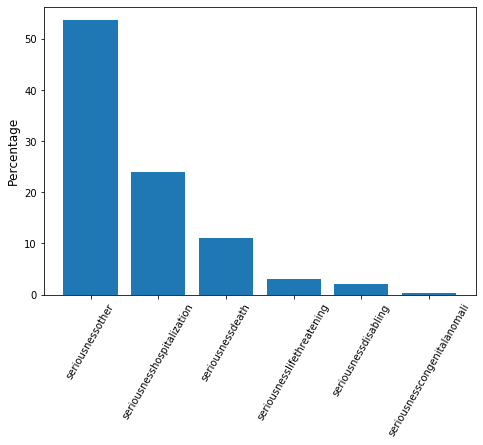

In [14]:
seriousness = (df[cols_seriousness].notna().sum().sort_values(ascending = False)*100/12000).reset_index().rename(columns={'index': 'seriousness', 0: 'percentage'})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(seriousness['seriousness'],seriousness['percentage'],)
plt.xticks(rotation=60)
plt.ylabel('Percentage', fontsize=12)
plt.show()

### The first 20 most frequent medical product

In [15]:
print('The first 20 most frequent medical product in percentage:')
cols_medicalproduct = df.columns[df.columns.str.contains('medical')]
df[cols_medicalproduct].notna().sum().sort_values(ascending = False)[:20]/12000*100

The first 20 most frequent medical product in percentage:


medicalproduct_RANITIDINE.           8.891667
medicalproduct_ZANTAC                7.975000
medicalproduct_OMEPRAZOLE.           5.108333
medicalproduct_PREDNISONE.           5.033333
medicalproduct_RANITIDINE CAPSULE    3.750000
medicalproduct_TRUVADA               3.558333
medicalproduct_FOLIC ACID.           3.458333
medicalproduct_METHOTREXATE.         3.208333
medicalproduct_HUMALOG               3.133333
medicalproduct_DEXAMETHASONE.        2.900000
medicalproduct_AMLODIPINE            2.841667
medicalproduct_GABAPENTIN.           2.658333
medicalproduct_KEYTRUDA              2.625000
medicalproduct_ATORVASTATIN          2.558333
medicalproduct_METFORMIN             2.450000
medicalproduct_HUMIRA                2.375000
medicalproduct_LISINOPRIL.           2.316667
medicalproduct_PANTOPRAZOLE          2.275000
medicalproduct_REVLIMID              2.225000
medicalproduct_VIREAD                2.166667
dtype: float64

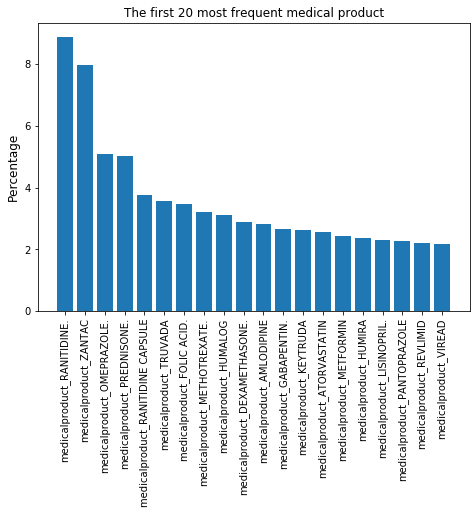

In [16]:
medicalproduct = (df[cols_medicalproduct].notna().sum().sort_values(ascending = False)[:20]*100/12000).reset_index().rename(columns={'index': 'medicalproduct', 0: 'percentage'})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(medicalproduct['medicalproduct'],medicalproduct['percentage'],)
plt.xticks(rotation=90)
plt.ylabel('Percentage', fontsize=12)
plt.title('The first 20 most frequent medical product')
plt.show()

### The first 20 most frequent reactions

In [17]:
cols_reaction = df.columns[df.columns.str.contains('reaction')]
df[cols_reaction].notna().sum().sort_values(ascending = False)[1:21]*100/12000

reaction_Drug ineffective               6.400000
reaction_Off label use                  5.375000
reaction_Fatigue                        4.383333
reaction_Pain                           4.366667
reaction_Death                          4.141667
reaction_Diarrhoea                      3.966667
reaction_Nausea                         3.883333
reaction_Headache                       2.991667
reaction_Product dose omission issue    2.933333
reaction_Dyspnoea                       2.866667
reaction_Anxiety                        2.541667
reaction_Dizziness                      2.425000
reaction_Arthralgia                     2.391667
reaction_Vomiting                       2.391667
reaction_Rash                           2.383333
reaction_Chronic kidney disease         2.325000
reaction_Bone density decreased         2.250000
reaction_Fall                           2.108333
reaction_Pyrexia                        2.100000
reaction_Asthenia                       1.966667
dtype: float64

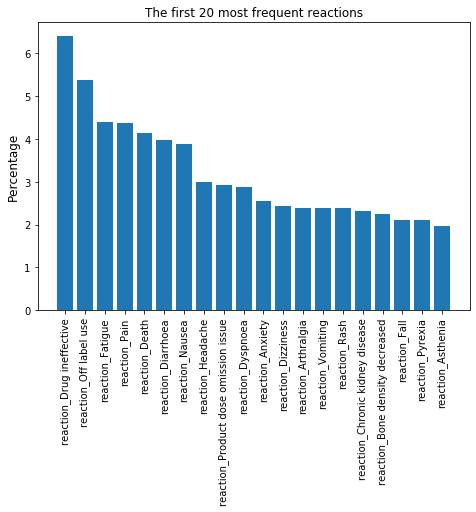

In [18]:
reactions = (df[cols_reaction].notna().sum().sort_values(ascending = False)[1:21]*100/12000).reset_index().rename(columns={'index': 'reaction', 0: 'percentage'})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(reactions['reaction'],reactions['percentage'],)
plt.xticks(rotation=90)
plt.ylabel('Percentage', fontsize=12)
plt.title('The first 20 most frequent reactions')
plt.show()

### The first 20 most frequent reported drugs from AstraZeneca

In [19]:
df_AZ = df.loc[df['companynumb'].str.contains('ASTRAZENECA') == True]

df_AZ[cols_medicalproduct].notna().sum().sort_values(ascending = False)[:20]*100/12000

medicalproduct_TAGRISSO          1.641667
medicalproduct_NEXIUM            0.383333
medicalproduct_PRILOSEC          0.316667
medicalproduct_NEXIUM 24HR       0.225000
medicalproduct_OMEPRAZOLE.       0.225000
medicalproduct_PREVACID          0.216667
medicalproduct_PRILOSEC OTC      0.200000
medicalproduct_PROTONIX          0.166667
medicalproduct_FUROSEMIDE.       0.150000
medicalproduct_PREDNISONE.       0.141667
medicalproduct_ASPIRIN.          0.133333
medicalproduct_LISINOPRIL.       0.133333
medicalproduct_IRESSA            0.133333
medicalproduct_ATORVASTATIN      0.125000
medicalproduct_PANTOPRAZOLE      0.108333
medicalproduct_GEFITINIB.        0.108333
medicalproduct_AMLODIPINE        0.108333
medicalproduct_METFORMIN         0.100000
medicalproduct_CIPROFLOXACIN.    0.100000
medicalproduct_BYDUREON BCISE    0.100000
dtype: float64

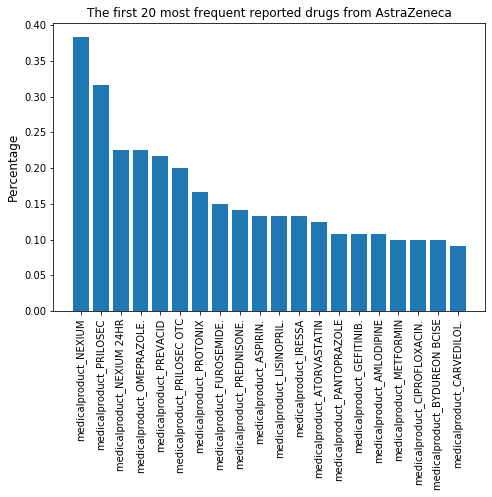

In [20]:
AZ_medicalproduct = (df_AZ[cols_medicalproduct].notna().sum().sort_values(ascending = False)[1:21]*100/12000).reset_index().rename(columns={'index': 'AZ_medicalproduct', 0: 'percentage'})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(AZ_medicalproduct['AZ_medicalproduct'],AZ_medicalproduct['percentage'],)
plt.xticks(rotation=90)
plt.ylabel('Percentage', fontsize=12)
plt.title('The first 20 most frequent reported drugs from AstraZeneca')
plt.show()

### The first 20 countries that had the most frequent reported events

In [21]:
print('The first 20 countries that had the most frequent reported event rates:')
df['primarysource_reportercountry'].value_counts()[:20]*100/12000

The first 20 countries that had the most frequent reported event rates:


US                       57.250000
COUNTRY NOT SPECIFIED     9.175000
CA                        7.916667
FR                        3.758333
GB                        3.716667
JP                        3.275000
DE                        2.450000
IT                        1.450000
NL                        1.250000
CN                        1.000000
ES                        0.916667
AU                        0.825000
BR                        0.691667
IN                        0.500000
PT                        0.375000
TR                        0.366667
CH                        0.325000
PL                        0.316667
SE                        0.275000
IL                        0.250000
Name: primarysource_reportercountry, dtype: float64

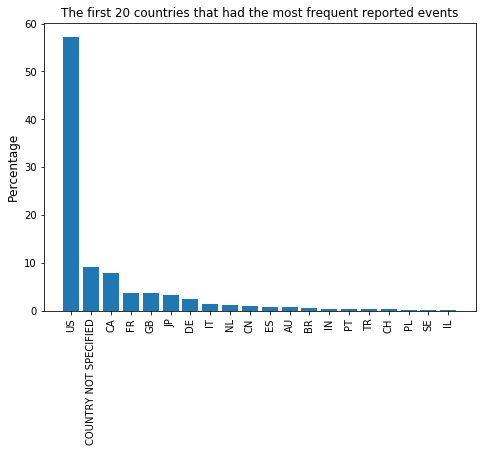

In [22]:
country = (df['primarysource_reportercountry'].value_counts()[:20]*100/12000).reset_index().rename(columns={'index': 'country', 'primarysource_reportercountry': 'percentage'})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(country['country'],country['percentage'])
plt.xticks(rotation=90)
plt.ylabel('Percentage', fontsize=12)
plt.title('The first 20 countries that had the most frequent reported events')
plt.show()

### Adverse events that related to COVID

In [23]:
### Find the columns names that include COVID
cols_covid = df.columns[df.columns.str.contains('COVID')|df.columns.str.contains('covid')]
df[cols_covid].notna().sum().sort_values(ascending = False)[:20]

reaction_COVID-19                                  193
reaction_COVID-19 pneumonia                         27
medicalproduct_COVID?19 VACCINE NOS.                15
reaction_Suspected COVID-19                         12
medicalproduct_COVID?19 VACCINE                     12
medicalproduct_ASTRAZENECA COVID?19 VACCINE          8
medicalproduct_PFIZER?BIONTECH COVID?19 VACCINE      6
medicalproduct_MODERNA COVID?19 VACCINE              4
medicalproduct_COVID VACCINE                         3
reaction_COVID-19 immunisation                       1
medicalproduct_COVID 19?VACCINE                      1
reaction_COVID-19 treatment                          1
dtype: int64

### AZ vaccine

In [24]:
AZ_vaccine = df.loc[df['medicalproduct_ASTRAZENECA COVID?19 VACCINE'] == 1]

In [25]:
#into a dataframe with the column names and number of not na values
df_column = df.loc[df['medicalproduct_ASTRAZENECA COVID?19 VACCINE'] == 1].notna().sum().sort_values(ascending = False).reset_index().rename(columns={'index': 'column_name', 0: 'freq'})

### Reactions related to AZ vaccine

In [26]:
# keep the columns that have values
df_column = df_column.loc[df_column['freq'] > 0]
df_column.loc[df_column['column_name'].str.contains('reaction')]

column_name  freq
12           patient_reaction     8
35          reaction_Headache     3
36           reaction_Malaise     3
37           reaction_Fatigue     2
38           reaction_Syncope     2
40     reaction_Swelling face     1
41       reaction_Photophobia     1
42            reaction_Tremor     1
43           reaction_Pyrexia     1
44           reaction_Myalgia     1
46  reaction_Humerus fracture     1
49      reaction_Eye swelling     1
52          reaction_Insomnia     1
58            reaction_Chills     1
59          reaction_Eye pain     1
63  reaction_Drug interaction     1
66              reaction_Fall     1
68         reaction_Neck pain     1

### Medical product that was taken together with AZ vaccine

In [27]:
df_column.loc[df_column['column_name'].str.contains('medical')]

column_name  freq
2   medicalproduct_ASTRAZENECA COVID?19 VACCINE     8
34                    medicalproduct_IBUPROFEN.     4
39                    medicalproduct_FLUOXETINE     1
47                 medicalproduct_FLUOROURACIL.     1
48                   medicalproduct_PARACETAMOL     1
50                   medicalproduct_PROPRANOLOL     1
51              medicalproduct_LISDEXAMFETAMINE     1
53                     medicalproduct_RAMIPRIL.     1
54       medicalproduct_EZETIMIBE 10 MG TABLETS     1
55       medicalproduct_INFLUENZA VIRUS ANTIGEN     1
56                   medicalproduct_BETAHISTINE     1
57                   medicalproduct_IRBESARTAN.     1
60                           medicalproduct_3TC     1
61                   medicalproduct_QUETIAPINE.     1
62               medicalproduct_INFLUENZA VIRUS     1
64                    medicalproduct_SERTRALINE     1
65                  medicalproduct_ATORVASTATIN     1
67                    medicalproduct_DONEPEZIL.     1

### Correlation of seriousness with the most frequent reactions

In [28]:


col_seriousness_reactions = ['reaction_Drug ineffective','reaction_Off label use', 'reaction_Fatigue', 'reaction_Pain',
                             'reaction_Death', 'reaction_Diarrhoea', 'reaction_Nausea',
                             'reaction_Headache', 'reaction_Product dose omission issue',
                             'reaction_Dyspnoea', 'reaction_Anxiety', 'reaction_Dizziness',
                             'reaction_Arthralgia', 'reaction_Vomiting', 'reaction_Rash',
                             'reaction_Chronic kidney disease', 'reaction_Bone density decreased',
                             'reaction_Fall', 'reaction_Pyrexia','seriousnessother', 'seriousnesshospitalization', 'seriousnessdeath',
                             'seriousnesslifethreatening', 'seriousnessdisabling','seriousnesscongenitalanomali']

correlation_mat = df[col_seriousness_reactions].astype(float).fillna(0.0)
corr_matrix = correlation_mat.corr()
corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
#sns.heatmap(correlation_mat)

In [29]:

def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

# find the values that are smaller than 1 and larger than 0.5
a = np.array(corr_matrix)
b = np.where((a>0.5)&(a<1))
c = np.unique(a[b]).tolist()
# Get list of index positions i.e. row & column of all occurrences of 81 in the dataframe

print('Index positions of values that is smaller than 1 and larger than 0.5 : ')
for corr in c:
    listOfPositions = getIndexes(corr_matrix, corr)
    for i in range(len(listOfPositions)):
        print('For correlation value',corr,': Position ', i, ' (Row index , Column Name) : ', listOfPositions[i])

Index positions of values that is smaller than 1 and larger than 0.5 : 
For correlation value 0.5869187358555902 : Position  0  (Row index , Column Name) :  ('seriousnessdeath', 'reaction_Death')
For correlation value 0.5869187358555902 : Position  1  (Row index , Column Name) :  ('reaction_Death', 'seriousnessdeath')


### Comment: It is obvious that 'seriousnessdeath', 'reaction_Death' should be highly correlated. We could lower the threshold from 0.5 and see if there are correlations between the seriousness and the reactions

### Correlations of seriousness with the most frequent medical products

In [30]:
col_seriousness_medicalproduct = ['seriousnessother', 'seriousnesshospitalization', 'seriousnessdeath',
                                  'seriousnesslifethreatening', 'seriousnessdisabling','seriousnesscongenitalanomali',
                                  'medicalproduct_RANITIDINE.', 'medicalproduct_ZANTAC','medicalproduct_OMEPRAZOLE.',
                                  'medicalproduct_PREDNISONE.','medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_TRUVADA',
                                  'medicalproduct_FOLIC ACID.', 'medicalproduct_METHOTREXATE.',
                                  'medicalproduct_HUMALOG', 'medicalproduct_DEXAMETHASONE.',
                                  'medicalproduct_AMLODIPINE', 'medicalproduct_GABAPENTIN.',
                                  'medicalproduct_KEYTRUDA', 'medicalproduct_ATORVASTATIN',
                                  'medicalproduct_METFORMIN', 'medicalproduct_HUMIRA',
                                  'medicalproduct_LISINOPRIL.', 'medicalproduct_PANTOPRAZOLE',
                                  'medicalproduct_REVLIMID', 'medicalproduct_VIREAD']

correlation_mat = df[col_seriousness_medicalproduct].astype(float).fillna(0.0)

corr_matrix = correlation_mat.corr()
corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [31]:
# find the values that are smaller than 1 and larger than 0.5
a = np.array(corr_matrix)
b = np.where((a>0.5)&(a<1))
c = np.unique(a[b]).tolist()
# Get list of index positions i.e. row & column of all occurrences of 81 in the dataframe

print('Index positions of values that is smaller than 1 and larger than 0.5 : ')
for corr in c:
    listOfPositions = getIndexes(corr_matrix, corr)
    for i in range(len(listOfPositions)):
        print('For correlation value',corr,': Position ', i, ' (Row index , Column Name) : ', listOfPositions[i])

Index positions of values that is smaller than 1 and larger than 0.5 : 
For correlation value 0.6117992574928529 : Position  0  (Row index , Column Name) :  ('medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_RANITIDINE.')
For correlation value 0.6117992574928529 : Position  1  (Row index , Column Name) :  ('medicalproduct_RANITIDINE.', 'medicalproduct_RANITIDINE CAPSULE')
For correlation value 0.642980866704843 : Position  0  (Row index , Column Name) :  ('medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_ZANTAC')
For correlation value 0.642980866704843 : Position  1  (Row index , Column Name) :  ('medicalproduct_ZANTAC', 'medicalproduct_RANITIDINE CAPSULE')
For correlation value 0.666608825232628 : Position  0  (Row index , Column Name) :  ('medicalproduct_VIREAD', 'medicalproduct_TRUVADA')
For correlation value 0.666608825232628 : Position  1  (Row index , Column Name) :  ('medicalproduct_TRUVADA', 'medicalproduct_VIREAD')
For correlation value 0.8493777421630949 : Position  0  

### Summary: The medications that highly correlated tend to be taken together: 
* 'medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_RANITIDINE.'
* 'medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_ZANTAC'
* 'medicalproduct_VIREAD', 'medicalproduct_TRUVADA'
* 'medicalproduct_ZANTAC', 'medicalproduct_RANITIDINE.

### Correlations of the first 20 most frequent reactions with the first 20 most frequent medical products

In [32]:
col_reaction_medicalproduct = [ 'medicalproduct_RANITIDINE.', 'medicalproduct_ZANTAC','medicalproduct_OMEPRAZOLE.',
                                  'medicalproduct_PREDNISONE.','medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_TRUVADA',
                                  'medicalproduct_FOLIC ACID.', 'medicalproduct_METHOTREXATE.',
                                  'medicalproduct_HUMALOG', 'medicalproduct_DEXAMETHASONE.',
                                  'medicalproduct_AMLODIPINE', 'medicalproduct_GABAPENTIN.',
                                  'medicalproduct_KEYTRUDA', 'medicalproduct_ATORVASTATIN',
                                  'medicalproduct_METFORMIN', 'medicalproduct_HUMIRA',
                                  'medicalproduct_LISINOPRIL.', 'medicalproduct_PANTOPRAZOLE',
                                  'medicalproduct_REVLIMID', 'medicalproduct_VIREAD',
                                  'reaction_Drug ineffective','reaction_Off label use', 'reaction_Fatigue', 'reaction_Pain',
                                  'reaction_Death', 'reaction_Diarrhoea', 'reaction_Nausea',
                                  'reaction_Headache', 'reaction_Product dose omission issue',
                                  'reaction_Dyspnoea', 'reaction_Anxiety', 'reaction_Dizziness',
                                  'reaction_Arthralgia', 'reaction_Vomiting', 'reaction_Rash',
                                  'reaction_Chronic kidney disease', 'reaction_Bone density decreased',
                                  'reaction_Fall', 'reaction_Pyrexia']
correlation_mat = df[col_reaction_medicalproduct].astype(float).fillna(0.0)

corr_matrix = correlation_mat.corr()
corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [33]:
# find the values that are smaller than 1 and larger than 0.5
a = np.array(corr_matrix)
b = np.where((a>0.5)&(a<1))
c = np.unique(a[b]).tolist()
# Get list of index positions i.e. row & column of all occurrences of 81 in the dataframe

print('Index positions of values that is smaller than 1 and larger than 0.5 : ')
for corr in c:
    listOfPositions = getIndexes(corr_matrix, corr)
    for i in range(len(listOfPositions)):
        print('For correlation value',corr,': Position ', i, ' (Row index , Column Name) : ', listOfPositions[i])

Index positions of values that is smaller than 1 and larger than 0.5 : 
For correlation value 0.5833615313021225 : Position  0  (Row index , Column Name) :  ('reaction_Bone density decreased', 'medicalproduct_VIREAD')
For correlation value 0.5833615313021225 : Position  1  (Row index , Column Name) :  ('medicalproduct_VIREAD', 'reaction_Bone density decreased')
For correlation value 0.6117992574928529 : Position  0  (Row index , Column Name) :  ('medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_RANITIDINE.')
For correlation value 0.6117992574928529 : Position  1  (Row index , Column Name) :  ('medicalproduct_RANITIDINE.', 'medicalproduct_RANITIDINE CAPSULE')
For correlation value 0.6260476006768159 : Position  0  (Row index , Column Name) :  ('reaction_Bone density decreased', 'medicalproduct_TRUVADA')
For correlation value 0.6260476006768159 : Position  1  (Row index , Column Name) :  ('medicalproduct_TRUVADA', 'reaction_Bone density decreased')
For correlation value 0.642980866704

### Summary: The following reactions are highly correlated with the following medical product
* 'reaction_Bone density decreased', 'medicalproduct_VIREAD'
* 'reaction_Bone density decreased', 'medicalproduct_TRUVADA'


### Clustering medical product/drugs that used together

In [34]:
col_medicalproduct = [ 'medicalproduct_RANITIDINE.', 'medicalproduct_ZANTAC','medicalproduct_OMEPRAZOLE.',
                      'medicalproduct_PREDNISONE.','medicalproduct_RANITIDINE CAPSULE', 'medicalproduct_TRUVADA',
                      'medicalproduct_FOLIC ACID.', 'medicalproduct_METHOTREXATE.',
                      'medicalproduct_HUMALOG', 'medicalproduct_DEXAMETHASONE.',
                      'medicalproduct_AMLODIPINE', 'medicalproduct_GABAPENTIN.',
                      'medicalproduct_KEYTRUDA', 'medicalproduct_ATORVASTATIN',
                      'medicalproduct_METFORMIN', 'medicalproduct_HUMIRA',
                      'medicalproduct_LISINOPRIL.', 'medicalproduct_PANTOPRAZOLE',
                      'medicalproduct_REVLIMID', 'medicalproduct_VIREAD']


#g = sns.clustermap(df[col_medicalproduct].astype(float).fillna(0), metric="correlation")

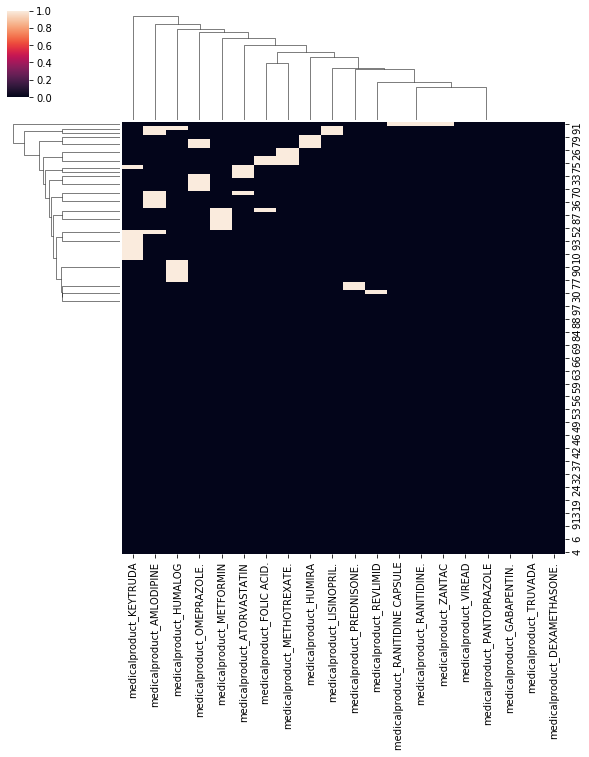

In [35]:
df_med = df[col_medicalproduct].astype(float).fillna(0)
g = sns.clustermap(df_med.head(100))

## Further analysis that could be considered that were not tackled due to limited time 

* Find the explaination/description of each field in the report (I found a doc named 'fileds' but it does not have all the files in advert event reports)
* Get ride of duplicates.
* Extract the drug indication. 
* This clustering map could be improved.
* Clustering for drugs that used together uses more complex methods.




In [36]:
df['duplicate'].value_counts()

1    11635
Name: duplicate, dtype: int64